Missing values in training dataset:
 r_qp_QPlogBB      10
r_qp_QPlogPo/w    10
r_qp_dipole       10
r_qp_IP(eV)       10
r_qp_QPPCaco      10
dtype: int64
Missing values in validation dataset:
 r_qp_QPlogBB      7
r_qp_QPlogPo/w    7
r_qp_dipole       7
r_qp_IP(eV)       7
r_qp_QPPCaco      7
dtype: int64


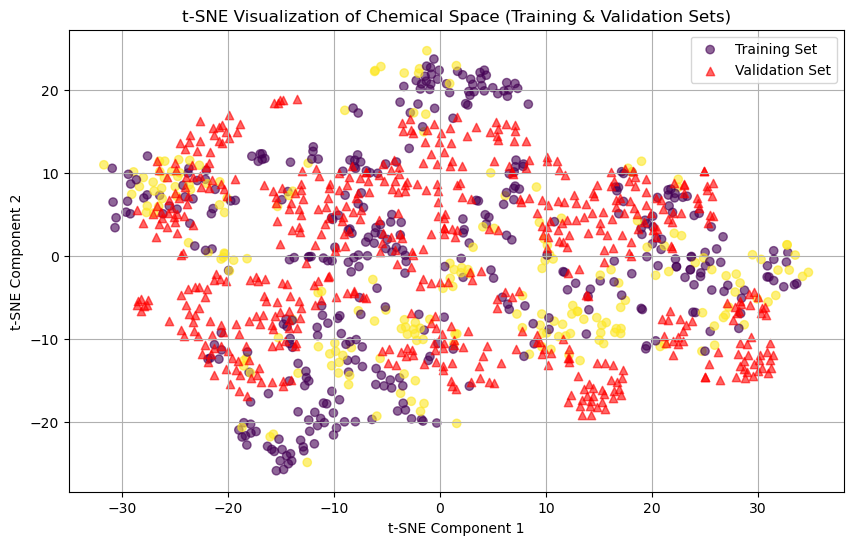

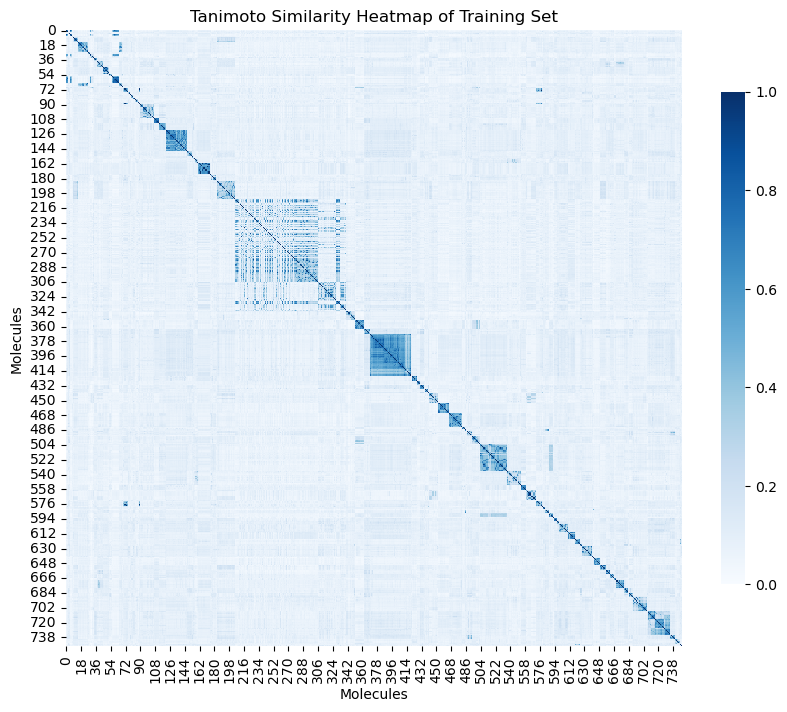

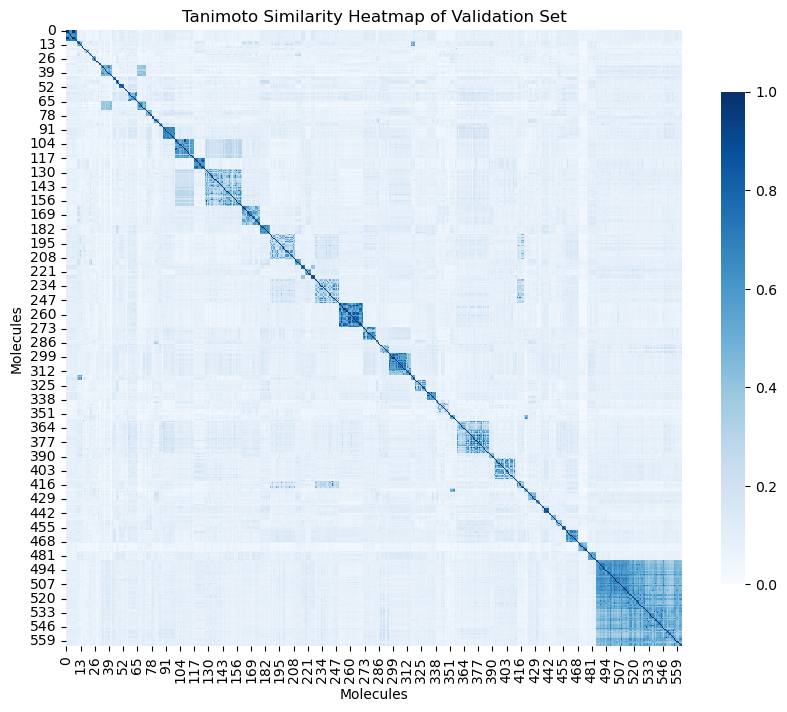

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import PandasTools, DataStructs
from rdkit.Chem import rdFingerprintGenerator
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load SDF file and convert to DataFrame for training dataset
sdf_file = "Structures_759_training.sdf"  
df = PandasTools.LoadSDF(sdf_file, smilesName='SMILES', molColName='Molecule', includeFingerprints=False)

# Load SDF file and convert to DataFrame for validation dataset
sdf_file_unseen = "Structures_test_571.sdf"  # Local path
df_validation = PandasTools.LoadSDF(sdf_file_unseen, smilesName='SMILES', molColName='Molecule', includeFingerprints=False)

# Important feature selection
selected_columns = [
    'r_qp_QPlogBB', 'r_qp_QPlogPo/w', 'r_qp_dipole', 'r_qp_IP(eV)', 'r_qp_QPPCaco'
]

# Check for missing values and drop them for both datasets
print("Missing values in training dataset:\n", df[selected_columns].isnull().sum())
print("Missing values in validation dataset:\n", df_validation[selected_columns].isnull().sum())

# Drop rows with missing values for the training and validation datasets
df_cleaned = df.dropna(subset=selected_columns)
df_validation_cleaned = df_validation.dropna(subset=selected_columns)

# Ensure the 'Stable' column exists and prepare datasets
if 'Stable' not in df_cleaned.columns:
    raise ValueError("The 'Stable' column is missing from the training DataFrame.")

# Prepare features and labels for training
features = df_cleaned[selected_columns].reset_index(drop=True)
labels = df_cleaned['Stable'].reset_index(drop=True).astype(int)

# Split the training dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

# t-SNE for training dataset
tsne_train = TSNE(n_components=2, random_state=42)
tsne_results_train = tsne_train.fit_transform(scaled_train)

# t-SNE for validation dataset (unseen data)
scaled_validation = scaler.transform(df_validation_cleaned[selected_columns].reset_index(drop=True))
tsne_validation = TSNE(n_components=2, random_state=42)
tsne_results_validation = tsne_validation.fit_transform(scaled_validation)

# Plotting t-SNE results for training, test, and validation datasets
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results_train[:, 0], tsne_results_train[:, 1], c=y_train, cmap='viridis', alpha=0.6, label='Training Set', marker='o')
plt.scatter(tsne_results_validation[:, 0], tsne_results_validation[:, 1], color='red', alpha=0.6, label='Validation Set', marker='^')
plt.title('t-SNE Visualization of Chemical Space (Training & Validation Sets)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid()
plt.show()

# Calculate Tanimoto similarity for the training dataset using Extended Fingerprints
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3)

# Generate Morgan fingerprints for training dataset
fingerprints_train = []
for smiles in df_cleaned['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = morgan_gen.GetFingerprint(mol)
        fingerprints_train.append(fp)

# Create a Tanimoto similarity matrix for training fingerprints
num_fps_train = len(fingerprints_train)
similarity_matrix_train = np.zeros((num_fps_train, num_fps_train))
for i in range(num_fps_train):
    for j in range(num_fps_train):
        similarity_matrix_train[i][j] = DataStructs.TanimotoSimilarity(fingerprints_train[i], fingerprints_train[j])

# Plot Tanimoto similarity heatmap for training dataset
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix_train, cmap='Blues', cbar_kws={"shrink": .8}, square=True)
plt.title('Tanimoto Similarity Heatmap of Training Set')
plt.xlabel('Molecules')
plt.ylabel('Molecules')
plt.show()

# Calculate Tanimoto similarity for the validation dataset
fingerprints_validation = []
for smiles in df_validation_cleaned['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = morgan_gen.GetFingerprint(mol)
        fingerprints_validation.append(fp)

# Create a Tanimoto similarity matrix for validation fingerprints
num_fps_validation = len(fingerprints_validation)
similarity_matrix_validation = np.zeros((num_fps_validation, num_fps_validation))
for i in range(num_fps_validation):
    for j in range(num_fps_validation):
        similarity_matrix_validation[i][j] = DataStructs.TanimotoSimilarity(fingerprints_validation[i], fingerprints_validation[j])

# Plot Tanimoto similarity heatmap for validation dataset
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix_validation, cmap='Blues', cbar_kws={"shrink": .8}, square=True)
plt.title('Tanimoto Similarity Heatmap of Validation Set')
plt.xlabel('Molecules')
plt.ylabel('Molecules')
plt.show()